In [7]:
import torch
import torch.nn as nn
import numpy as np
import sys, os
import matplotlib.pyplot as plt
from MCEVAE import *
from utils import *

In [8]:
start_index = 600
nimages = 40
dtype = 'test' 
transformation = 'se2'
nCat = 10
d_zc = 10
d_zvar = 3
hidden_z_c = 512
hidden_z_var = 512
aug_enc_type = 'linear'
classifier = 'vade'
training_mode = 'unsupervised'
tag = 'default'
mnist_SE2 = torch.from_numpy(np.load('mnist_' + transformation + '_' + dtype +'.npy'))[:10000]
mnist_SE2_init = torch.from_numpy(np.load('mnist_init_' + transformation + '_' + dtype + '.npy'))[:10000]
mnist_SE2_target = torch.from_numpy(np.load('mnist_target_' + transformation + '_' + dtype + '.npy'))[:10000]
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [9]:
model = MCEVAE(in_size=784,
                   aug_dim=784,
                   latent_z_c=nCat,
                   latent_n_c=d_zc,
                   latent_z_var=d_zvar,
                   aug_enc_type=aug_enc_type,
                   mode=transformation.upper(), 
                   invariance_decoder='gated', 
                   rec_loss='bce', 
                   classifier=classifier,
                   in_dim=1, 
                   out_dim=1, 
                   hidden_z_c=hidden_z_c,
                   hidden_z_var=hidden_z_var,
                   hidden_tau=32, 
                   activation=nn.Sigmoid,
                   training_mode=training_mode,
                   device = device,
                   tag = tag).to(device)

lr = 2e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)

modelname = "model_{}_aug_{}_inv_{}_nc_{}_dc_{}_dvar_{}_class_{}_{}_{}_checkpoint".format(model.mode, 
                                                                                        model.aug_enc_type,
                                                                                        model.invariance_decoder,
                                                                                        model.latent_n_c,
                                                                                        model.latent_z_c,
                                                                                        model.latent_z_var,
                                                                                        model.classifier,
                                                                                        model.tag,
                                                                                        model.training_mode,
                                                                                        model.rec_loss)


model, optim, epoch = load_checkpoint(model, optim, 'models/' + modelname)
model = model.to(device)

in_size: 784, aug enc:linear, latent_z_c: 10, latent_z_var:3, mode: SE2, sem_dec: gated, rec_loss: bce, classifier: vade
=> loading checkpoint 'models/model_SE2_aug_linear_inv_gated_nc_10_dc_10_dvar_3_class_vade_default_unsupervised_checkpoint'
=> loaded checkpoint 'models/model_SE2_aug_linear_inv_gated_nc_10_dc_10_dvar_3_class_vade_default_unsupervised_checkpoint' (epoch 5)


In [10]:
with torch.no_grad():
    x = mnist_SE2.to(device)
    x_init = mnist_SE2_init.to(device)    
    x_hat, z_var_q, z_var_q_mu, z_var_q_logvar, \
    z_c_q, z_c_q_mu, z_c_q_logvar, z_c_q_L, \
    tau_q, tau_q_mu, tau_q_logvar, x_rec, M = model(x)

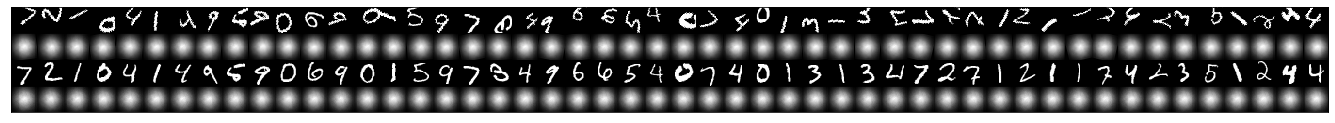

In [11]:
x = x.cpu()
x_hat = x_hat.cpu()
x_rec = x_rec.cpu()
x_init = x_init.cpu()

def plotter(nrow, ncol, subplot_index, dataset, start_index = 0, nimages= 50):
    plt.subplot(nrow,ncol, subplot_index)
    images = dataset[start_index].reshape((28,-1))
    for i in range(start_index+1,start_index+nimages):
        images = np.append(images, dataset[i].reshape((28,-1)), 1)
    plt.tight_layout()
    plt.imshow(images, cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)


fig = plt.figure(figsize=(nimages*0.5,2))
plotter(4,1,1, x)
plotter(4,1,2, x_hat)
plotter(4,1,3, x_init)
plotter(4,1,4, x_rec)
plt.savefig("images/" + modelname.replace("_checkpoint",".png"))

In [60]:
from sklearn.mixture import GaussianMixture

def gmm_clustering(z_c_q, nC):
    GM = GaussianMixture(n_components = nC, covariance_type = 'diag').fit(z_c_q.detach().cpu().numpy())
    return GM
nC = 15
GM = gmm_clustering(z_c_q, nC)
x_prob = torch.tensor(GM.predict_proba(z_c_q.detach().cpu().numpy()))
x_assignment_indices = torch.max(x_prob, 1).indices
x_all_indices = list(range(x_prob.size()[0]))
x_prob = torch.zeros(x_prob.size())
x_prob[x_all_indices, x_assignment_indices] = 1.0

In [61]:
x_prob[[7,9,12,16,20],:]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [62]:
#model.pi_c()/torch.sum(model.pi_c())

In [63]:
#model.mu_c

In [64]:
#z_c_q_mu[6,:]

In [65]:
#model.gamma_c(z_c_q)[:,0]

In [66]:
image_map_x = {}
image_map_x_hat = {}
image_map_x_init = {}
image_map_x_rec = {}

all_x = {}
all_x_hat = {}
all_x_init = {}
all_x_rec = {}
all_x_prob = {}
for i in range(10):
    image_map_x[i] = []
    image_map_x_hat[i] = []
    image_map_x_init[i] = []
    image_map_x_rec[i] = []
    
    all_x[i]= []
    all_x_hat[i] = []
    all_x_init[i] = []
    all_x_rec[i] = []
    all_x_prob[i] = []

x = torch.clamp(x, 1.e-5, 1-1.e-5)
x_init = torch.clamp(x_init, 1.e-5, 1-1.e-5)
x_hat = torch.clamp(x_hat, 1.e-5, 1-1.e-5)
x_rec = torch.clamp(x_rec, 1.e-5, 1-1.e-5)
#x_prob = torch.transpose(model.gamma_c(z_c_q), 0,1)
y = mnist_SE2_target
rec_loss = torch.sum(-(x * torch.log(x_hat) + (1-x)*torch.log(1-x_hat)), dim=(1,2,3))

In [67]:
for ii in range(10):
    target = y[ii].item
    all_x[ii] = x[y == ii]
    all_x_hat[ii] = x_hat[y == ii]
    all_x_rec[ii] = x_rec[y == ii]
    all_x_init[ii] = x_init[y == ii]
    all_x_prob[ii] = x_prob[y == ii]
    losses = rec_loss[y == ii]
    _minsum = torch.min(torch.sum(all_x[ii], (1,2,3))).item()
    _maxsum = torch.max(torch.sum(all_x[ii], (1,2,3))).item()
    _minloss = torch.min(losses).item()
    for jj in range(all_x[ii].shape[0]):
        this_sum = torch.sum(all_x[ii][jj]).item()
        if this_sum > (_minsum + _maxsum)/4.0 \
        and len(image_map_x[ii]) < 4 \
        and losses[jj] < 1.5*_minloss:
            print("adding image for ", ii)
            image_map_x[ii].append(all_x[ii][jj])
            image_map_x_hat[ii].append(all_x_hat[ii][jj])
            image_map_x_rec[ii].append(all_x_rec[ii][jj])
            image_map_x_init[ii].append(all_x_init[ii][jj])
        

adding image for  0
adding image for  0
adding image for  0
adding image for  0
adding image for  1
adding image for  1
adding image for  1
adding image for  1
adding image for  2
adding image for  2
adding image for  2
adding image for  2
adding image for  3
adding image for  3
adding image for  3
adding image for  3
adding image for  4
adding image for  4
adding image for  4
adding image for  4
adding image for  5
adding image for  5
adding image for  5
adding image for  5
adding image for  6
adding image for  6
adding image for  6
adding image for  6
adding image for  7
adding image for  7
adding image for  7
adding image for  7
adding image for  8
adding image for  8
adding image for  8
adding image for  8
adding image for  9
adding image for  9
adding image for  9
adding image for  9


In [68]:
def recoSampler(keys = range(10)):
    im_x = []
    im_x_hat = []
    im_x_rec = []
    im_x_init = []
    for jj in keys:
        im_x = im_x + image_map_x[jj]
        im_x_hat = im_x_hat + image_map_x_hat[jj]
        im_x_rec = im_x_rec + image_map_x_rec[jj]
        im_x_init = im_x_init + image_map_x_init[jj]

    fig = plt.figure(figsize=(int(len(im_x)/2),2))
    plotter(4,1,1, im_x, 0, int(len(im_x)))
    plotter(4,1,2, im_x_hat, 0, int(len(im_x)))
    plotter(4,1,3, im_x_init, 0, int(len(im_x)))
    plotter(4,1,4, im_x_rec, 0, int(len(im_x)))

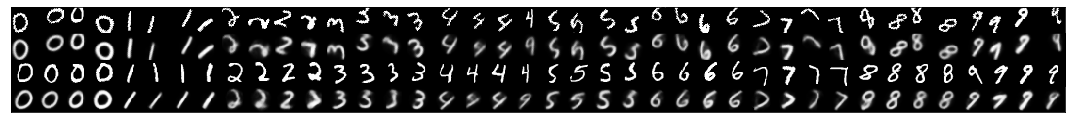

In [69]:
recoSampler([0,1,2,3,4,5,6,7,8,9])
plt.savefig("images/" + modelname.replace("_checkpoint", "_sample.png"))

In [70]:
all_x_prob[7][0:10]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

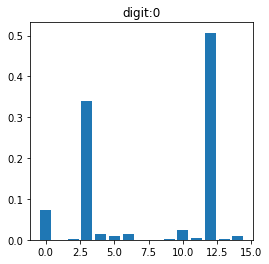

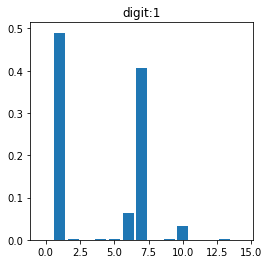

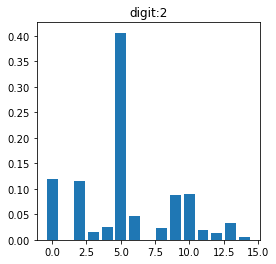

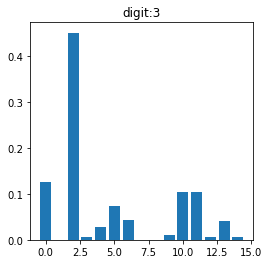

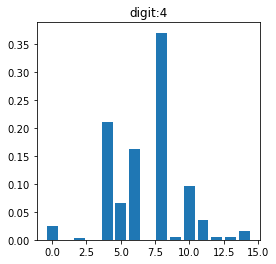

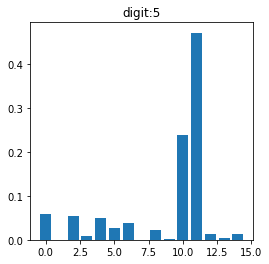

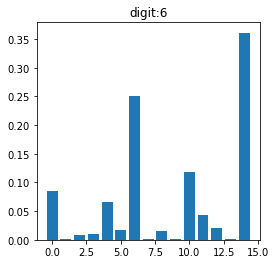

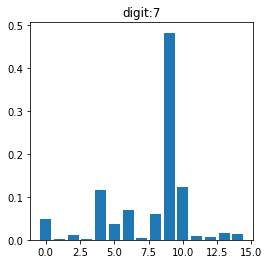

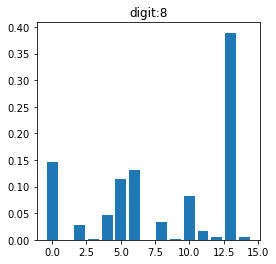

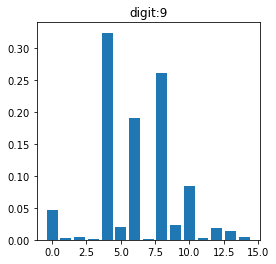

In [71]:
cats = np.arange(0,nC,1.0)
for ii in range(10):
    N = all_x_prob[ii].shape[0]
    this_probs = (torch.sum(all_x_prob[ii], 0)/N).detach().numpy()
    fig = plt.figure(figsize=(4, 4))
    plt.bar(cats, this_probs)
    plt.title("digit:{}".format(ii))

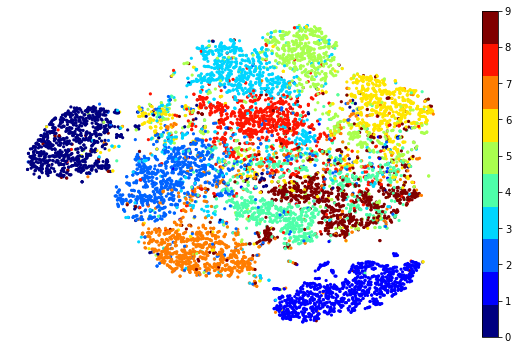

In [72]:
from sklearn.manifold import TSNE
if z_c_q.shape[0] > 0:
    tsne_features = TSNE(n_components=2).fit_transform(z_c_q.cpu().numpy())

    fig = plt.figure(figsize=(10, 6))

    plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=y[:tsne_features.shape[0]], marker='o',
                edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
    plt.grid(False)
    plt.axis('off')
    plt.colorbar()
    plt.savefig("images/" + modelname.replace("_checkpoint", "_clustermap.png"))

In [ ]:
if z_var_q.shape[0] > 0:
    tsne_features = TSNE(n_components=2).fit_transform(z_var_q.cpu().numpy())

    fig = plt.figure(figsize=(10, 6))

    plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=y[:tsne_features.shape[0]], marker='o',
                edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
    plt.grid(False)
    plt.axis('off')
    plt.colorbar()
    plt.savefig("images/" + modelname.replace("_checkpoint", "_clustermap_var.png"))